<a href="https://colab.research.google.com/github/DeepFluxion/IBMEC_Aprendizado_Reforco/blob/main/Aula_14_AC2/Aula_14_Atividade_Complementar_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📋Atividade Complementar 2 - Monte Carlo (Prediction e Control)

Você pode executar esta atividade no Google Colab ou executar no seu computador.

## 📊 Formato de Entrega

Use o template word (.docx) para download no SAVA e entregue um pdf:

### Para cada questão:
1. **Print/screenshot** do resultado principal (gráfico ou tabela de win rates)
2. **Respostas** para cada pergunta procure esclarecer os conceitos empregados
3. **Observação adicional** (opcional): algo interessante que você notou


## ✅ Critérios de Avaliação Simplificados

| Critério | Peso | O que avaliar |
|----------|------|---------------|
| **Execução** | 30% | Código rodou? Resultados presentes? |
| **Respostas** | 50% | Corretas e fundamentadas com os números obtidos? |
| **Clareza** | 20% | Bem organizado e fácil de ler? |

### Pontuação:

Cada questão vale 2 pontos

---

## 💡 Dicas Rápidas

1. **Tempo por questão**: ~18 minutos cada = 1h30 min total
2. **Use números**: Sempre cite os valores obtidos ("43.5% vs 41.2%")
3. **Prints importantes**: Capture os gráficos principais (win rates e políticas)
4. **Compare sempre**: As questões pedem comparações - use os números!

---

## 🎯 Meta de Aprendizado

Ao final destes exercícios você deve ser capaz de:

✓ **Questão 1-2**: Entender Prediction (avaliar política fixa) e impacto de episódios  
✓ **Questão 3**: Compreender o papel do epsilon (ε) na exploração vs exploitação  
✓ **Questão 4**: Entender MC ES Control e o conceito de Exploring Starts  
✓ **Questão 5**: Comparar todos os métodos e identificar quando usar cada um

**Boa sorte! 🎲🎯**

# Execute estes códigos ante de começar

## 1. First Visit Monte Carlo Prediction

O **método de predição Monte Carlo de primeira visita** (*First-Visit Monte Carlo Prediction*) é um algoritmo de **aprendizado por reforço** usado para **estimar a função de valor de estados $V(s)$** de uma política fixa $\pi$, **sem precisar conhecer o modelo do ambiente**.

Ele aprende a partir de episódios completos, ou seja, interações reais entre agente e ambiente, e estima os valores médios das recompensas recebidas.

O objetivo é estimar o **valor esperado de cada estado** $ s $ ao seguir uma política $ \pi $:

$$
V_\pi(s) = \mathbb{E}_\pi [G_t \mid S_t = s]
$$

onde:

- $ V_\pi(s) $: valor esperado do estado $ s $ sob a política $ \pi $;
- $G_t $: retorno total acumulado a partir do tempo $ t $:

$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}
$$

- $\gamma \in [0,1]$: fator de desconto, que pondera a importância das recompensas futuras;
- $R_t$: recompensa recebida na transição entre os estados;
- $\pi(a|s)$: política que define a probabilidade de escolher a ação $ a $ no estado $ s $.

A implementação está disponível neste [link](https://github.com/DeepFluxion/IBMEC_Aprendizado_Reforco/blob/main/Aula_13/Aula_13_First_Visit_MC_Prediction_Melhorado.ipynb)

In [ ]:
# Importações
from __future__ import annotations
import numpy as np
from collections import defaultdict
from typing import Callable, Dict, Tuple, List
import matplotlib.pyplot as plt
import gymnasium as gym

In [ ]:
# Tipagens
State = Tuple[int, int, bool]  # (player_sum, dealer_card, usable_ace)
Action = int                   # 0 = stick, 1 = hit
Policy = Callable[[State], Action]
ValueFunction = Dict[State, float]

In [ ]:
def generate_episode_fv_mc(env, policy: Policy):
    """
    Gera um episódio completo. Compatível com Gym e Gymnasium.

    Returns:
        trajectory: lista de (state, reward, done, action)
        T: índice do estado terminal
    """
    trajectory = []
    done = True
    At = None

    while True:
        if done:
            reset_ret = env.reset()
            if isinstance(reset_ret, tuple) and len(reset_ret) >= 1:
                St = reset_ret[0]
            else:
                St = reset_ret
            Rt = None
            done = False
        else:
            step_ret = env.step(At)
            # gymnasium: (obs, reward, terminated, truncated, info)
            if isinstance(step_ret, tuple) and len(step_ret) == 5:
                St, Rt, terminated, truncated, _ = step_ret
                done = bool(terminated or truncated)
            elif isinstance(step_ret, tuple) and len(step_ret) == 4:
                St, Rt, done, _ = step_ret
            elif isinstance(step_ret, tuple) and len(step_ret) == 3:
                St, Rt, done = step_ret
            else:
                St, Rt, done = step_ret[0], step_ret[1], step_ret[2]

        At = policy(St)
        trajectory.append((St, Rt, done, At))

        if done:
            break

    return trajectory, len(trajectory) - 1

In [ ]:
def first_visit_MC_prediction(env, policy: Policy, episodes: int = 10000,
                              gamma: float = 1.0, verbose: bool = False):
    """
    First-Visit Monte Carlo Prediction.

    Args:
        env: ambiente Gymnasium/Gym
        policy: função de política (state -> action)
        episodes: número de episódios
        gamma: fator de desconto
        verbose: se True, mostra progresso

    Returns:
        V: função de valor estimada {state: value}
    """
    Returns = defaultdict(list)
    V: ValueFunction = {}

    for ep in range(episodes):
        traj, T = generate_episode_fv_mc(env, policy)
        G = 0.0

        for t in range(T - 1, -1, -1):
            St, _, _, _ = traj[t]
            _, Rt_1, _, _ = traj[t + 1] if t + 1 < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1

            # First-visit check
            if St not in [traj[i][0] for i in range(0, t)]:
                Returns[St].append(G)
                V[St] = np.mean(Returns[St])

        if verbose and (ep + 1) % max(1, episodes // 10) == 0:
            print(f"Episódios: {ep+1}/{episodes}")

    return V

In [ ]:
# ============================================================================
# POLÍTICAS DE EXEMPLO
# ============================================================================

def policy_blackjack(state: State) -> Action:
    """
    Política simples: STICK se soma >= 20, senão HIT.
    """
    player_sum, dealer_card, usable_ace = state
    return 0 if player_sum >= 20 else 1


def policy_blackjack_advanced(state: State) -> Action:
    """
    Política heurística mais sofisticada para Blackjack.

    Estratégia:
    - Com ás utilizável: mais agressivo (ás flexível reduz risco)
    - Sem ás utilizável: mais conservador
    - Considera carta visível do dealer
    """
    player_sum, dealer_card, usable_ace = state

    if usable_ace:
        # Com ás utilizável (flexibilidade maior)
        if player_sum >= 19:
            return 0  # STICK com 19+
        elif 17 <= player_sum <= 18:
            return 0 if dealer_card <= 8 else 1  # depende do dealer
        else:
            return 1  # HIT abaixo de 17
    else:
        # Sem ás utilizável (risco maior de bust)
        if player_sum >= 17:
            return 0  # STICK com 17+
        elif 13 <= player_sum <= 16:
            return 1 if dealer_card >= 7 else 0  # dealer forte: HIT
        elif player_sum == 12:
            return 0 if 4 <= dealer_card <= 6 else 1  # dealer fraco: STICK
        else:
            return 1  # HIT sempre com 11 ou menos

In [ ]:
def value_to_array(V: ValueFunction, usable_ace: bool) -> np.ndarray:
    Vd = defaultdict(float, V)
    arr = np.zeros((10, 10))
    for player_sum in range(12, 22):
        for dealer_card in range(1, 11):
            arr[player_sum - 12, dealer_card - 1] = Vd[(player_sum, dealer_card, usable_ace)]
    return arr

# Plotting utilities (to be executed interactively in the notebook)
# import matplotlib.pyplot as plt

def plot_value_heatmap(V, title_prefix: str = "", state_values: bool = False,
                       fmt: str = '.2f'):
    """
    Plota heatmaps de V(s).
    PADRONIZADO com MC ES e On-Policy MC Control.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for ax, usable_ace in zip(axes, [True, False]):
        data = value_to_array(V, usable_ace)
        im = ax.imshow(data, cmap='viridis', origin='lower',
                      extent=[0.5, 10.5, 11.5, 21.5], aspect='auto')
        ax.set_title(f"{title_prefix}V(s) - usable_ace={usable_ace}", fontsize=12)
        ax.set_xlabel('Carta visível do dealer', fontsize=10)
        ax.set_ylabel('Soma do jogador', fontsize=10)
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))

        if state_values:
            nrows, ncols = data.shape
            for i in range(nrows):
                for j in range(ncols):
                    color = 'white' if data[i, j] < 0 else 'black'
                    ax.text(j + 1, i + 12, format(data[i, j], fmt),
                           ha='center', va='center', fontsize=7, color=color)

        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_convergence(env, policy, episodes: int = 30000, gamma: float = 1.0,
                    window: int = 100):
    """
    Plota convergência com média móvel.
    MELHORADO com 2 subplots e análise visual.
    """
    V = {}
    Returns = defaultdict(list)
    avg_values = []

    print(f"Calculando convergência para {episodes} episódios...")
    for ep in range(episodes):
        traj, T = generate_episode(env, policy)
        G = 0.0

        for t in range(T - 1, -1, -1):
            St, _, _, _ = traj[t]
            _, Rt_1, _, _ = traj[t + 1] if t + 1 < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1

            if St not in [traj[i][0] for i in range(0, t)]:
                Returns[St].append(G)
                V[St] = np.mean(Returns[St])

        avg_values.append(np.mean(list(map(abs, V.values()))) if V else 0)

        if (ep + 1) % max(1, episodes // 10) == 0:
            print(f"  {ep+1}/{episodes} episódios completos")

    # Plotar
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Subplot 1: Série completa
    ax1.plot(avg_values, alpha=0.3, linewidth=0.5, label='Valores brutos')

    if len(avg_values) > window:
        moving_avg = np.convolve(avg_values, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(avg_values)), moving_avg,
                linewidth=2, color='red', label=f'Média móvel ({window} ep)')

    ax1.set_ylabel('Valor médio absoluto |V(s)|', fontsize=10)
    ax1.set_title('Convergência do First-Visit MC Prediction', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Subplot 2: Últimos 20%
    start_idx = max(0, int(len(avg_values) * 0.8))
    ax2.plot(range(start_idx, len(avg_values)), avg_values[start_idx:],
            linewidth=1, alpha=0.7)
    ax2.set_xlabel('Episódios', fontsize=10)
    ax2.set_ylabel('Valor médio absoluto', fontsize=10)
    ax2.set_title('Zoom - Últimos 20% dos Episódios', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return V

In [ ]:
def value_dict_to_dataframe(V_dict, has_ace: bool) -> pd.DataFrame:
    """Converte V(s) dict em DataFrame pandas."""
    index = list(range(12, 22))
    cols = list(range(1, 11))
    data = []

    for ps in index:
        row = []
        for dc in cols:
            row.append(V_dict.get((ps, dc, has_ace), np.nan))
        data.append(row)

    df = pd.DataFrame(data, index=index, columns=cols)
    df.index.name = 'player_sum'
    df.columns.name = 'dealer_card'
    return df

In [ ]:
# ============================================================================
# AVALIAÇÃO DE PERFORMANCE
# ============================================================================

def avaliar_politica_prediction(env, policy: Policy, n_jogos: int = 10000,
                                verbose: bool = True):
    """
    Avalia performance de uma política de prediction no Blackjack.
    Adaptado para políticas que não usam Q-values.

    Args:
        env: ambiente Gym/Gymnasium
        policy: função de política
        n_jogos: número de jogos para avaliar
        verbose: se True, mostra detalhes

    Returns:
        dict com estatísticas
    """
    vitorias = 0
    derrotas = 0
    empates = 0
    recompensas = []

    for jogo in range(n_jogos):
        # Reset
        reset_ret = env.reset()
        state = reset_ret[0] if isinstance(reset_ret, tuple) else reset_ret
        done = False
        recompensa_episodio = 0

        # Jogar episódio
        while not done:
            action = policy(state)

            step_ret = env.step(action)
            if len(step_ret) == 5:  # Gymnasium
                state, reward, terminated, truncated, _ = step_ret
                done = terminated or truncated
            else:  # Gym
                state, reward, done, _ = step_ret

            recompensa_episodio = reward

        # Contabilizar
        recompensas.append(recompensa_episodio)
        if recompensa_episodio > 0:
            vitorias += 1
        elif recompensa_episodio < 0:
            derrotas += 1
        else:
            empates += 1

        # Progresso
        if verbose and (jogo + 1) % (n_jogos // 10) == 0:
            taxa_parcial = (vitorias / (jogo + 1)) * 100
            print(f"  Progresso: {jogo+1:>6}/{n_jogos} jogos | "
                  f"Win rate atual: {taxa_parcial:>5.2f}%")

    # Estatísticas
    taxa_vitoria = (vitorias / n_jogos) * 100
    taxa_derrota = (derrotas / n_jogos) * 100
    taxa_empate = (empates / n_jogos) * 100
    recompensa_media = np.mean(recompensas)

    stats = {
        'wins': vitorias,
        'losses': derrotas,
        'draws': empates,
        'total_games': n_jogos,
        'win_rate': taxa_vitoria,
        'loss_rate': taxa_derrota,
        'draw_rate': taxa_empate,
        'avg_reward': recompensa_media
    }

    if verbose:
        print("\n" + "="*60)
        print(" RESULTADOS DA AVALIAÇÃO")
        print("="*60)
        print(f"Total de jogos:  {n_jogos:>10,}")
        print("-"*60)
        print(f"Vitórias:        {vitorias:>10,}  ({taxa_vitoria:>6.2f}%)")
        print(f"Derrotas:        {derrotas:>10,}  ({taxa_derrota:>6.2f}%)")
        print(f"Empates:         {empates:>10,}  ({taxa_empate:>6.2f}%)")
        print("-"*60)
        print(f"Recompensa média: {recompensa_media:>9.4f}")
        print("="*60)

        # Interpretação
        print("\n📊 INTERPRETAÇÃO:")
        if taxa_vitoria >= 45:
            print("   🏆 EXCELENTE! Política muito forte.")
        elif taxa_vitoria >= 43:
            print("   ✅ ÓTIMO! Política próxima da ótima.")
        elif taxa_vitoria >= 40:
            print("   ✓ BOM! Política competitiva.")
        elif taxa_vitoria >= 35:
            print("   ⚠ RAZOÁVEL. Pode melhorar.")
        else:
            print("   ❌ FRACO. Política subótima.")

        print("\n📈 REFERÊNCIAS:")
        print("   - Estratégia aleatória:     ~28-30%")
        print("   - Estratégia dealer (≥17):  ~42-44%")
        print("   - Política ótima teórica:   ~43-46%")
        print("="*60)

    return stats

In [ ]:
def comparar_politicas_prediction(env, policies_dict: Dict[str, Policy],
                                  n_jogos: int = 10000):
    """
    Compara múltiplas políticas de prediction.

    Args:
        env: ambiente
        policies_dict: {"nome": função_política}
        n_jogos: número de jogos por política

    Returns:
        dict com resultados
    """
    print("\n" + "="*70)
    print(" COMPARAÇÃO DE POLÍTICAS")
    print("="*70)

    resultados = {}

    for nome, policy in policies_dict.items():
        print(f"\n[Testando] {nome}...")
        stats = avaliar_politica_prediction(env, policy, n_jogos, verbose=False)
        resultados[nome] = stats

        print(f"  ✓ Win Rate: {stats['win_rate']:.2f}%")
        print(f"  ✓ Avg Reward: {stats['avg_reward']:.4f}")

    # Plotar comparação
    _plot_comparison(resultados)

    return resultados


def _plot_comparison(results: Dict):
    """Plota comparação visual entre políticas."""
    names = list(results.keys())
    win_rates = [results[name]['win_rate'] for name in names]
    loss_rates = [results[name]['loss_rate'] for name in names]
    draw_rates = [results[name]['draw_rate'] for name in names]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Subplot 1: Barras empilhadas
    x = np.arange(len(names))
    width = 0.6

    ax1.bar(x, win_rates, width, label='Vitórias', color='green', alpha=0.8)
    ax1.bar(x, draw_rates, width, bottom=win_rates, label='Empates',
            color='gray', alpha=0.8)
    ax1.bar(x, loss_rates, width,
            bottom=np.array(win_rates) + np.array(draw_rates),
            label='Derrotas', color='red', alpha=0.8)

    ax1.set_ylabel('Porcentagem (%)', fontsize=10)
    ax1.set_title('Distribuição de Resultados', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, axis='y', alpha=0.3)

    # Subplot 2: Win rates
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(names)))
    bars = ax2.bar(x, win_rates, width, color=colors, alpha=0.8)

    ax2.set_ylabel('Win Rate (%)', fontsize=10)
    ax2.set_title('Taxa de Vitórias', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(names, rotation=45, ha='right')
    ax2.grid(True, axis='y', alpha=0.3)
    ax2.set_ylim([0, 100])

    for bar, wr in zip(bars, win_rates):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{wr:.2f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

## 2. First Visit Monte Carlo Control

O objetivo do **Monte Carlo Control (On-Policy)** é **aprender uma política ótima** $\pi$ para um ambiente de decisão sequencial **sem um modelo** do ambiente, usando apenas amostras (episódios).

Enquanto os métodos de *Prediction* estimam $V_\pi(s)$ para uma política fixa $\pi$, aqui queremos **aprender e melhorar** a política progressivamente, estimando a função-ação $Q_\pi(s,a)$ e tornando a política **greedy** em relação a $Q$ (com exploração ε-greedy para garantir visitas suficientes a todos os pares $(s,a)$).

Referência: Sutton, R. S. & Barto, A. G. (2018). *Reinforcement Learning: An Introduction*, Capítulo 5.4 (On-Policy First-Visit MC Control).

---

- **Função ação-valor**:

$$
Q_\pi(s,a) = \mathbb{E}_\pi\left[ G_t \mid S_t = s, A_t = a \right]
$$

- **Retorno**:

$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots
$$

- **Política ε-greedy** (para melhoria):

$$
\pi(a|s) = \begin{cases}
1 - \varepsilon + \dfrac{\varepsilon}{|\mathcal{A}(s)|}, & \text{se } a = \arg\max_a Q(s,a) \\
\dfrac{\varepsilon}{|\mathcal{A}(s)|}, & \text{caso contrário}
\end{cases}
$$

A implementação está disponível neste [link](https://github.com/DeepFluxion/IBMEC_Aprendizado_Reforco/blob/main/Aula_13/Aula_13_On_Policy_First_Visit_MC_Control.ipynb)

In [ ]:
# ============================================================================
# FUNÇÕES AUXILIARES
# ============================================================================

def argmax_rand(array):
    """Argmax com quebra de empates aleatória."""
    arr = np.array(array)
    choices = np.flatnonzero(arr == arr.max())
    return int(np.random.choice(choices))

# Política ε-greedy baseada em Q
def epsilon_greedy_from_q(Q: Dict[Tuple, float], state, n_actions: int, eps: float):
    """
    Retorna uma ação escolhida ε-greedy.

    Args:
        Q: dicionário com chaves (state, action)
        state: estado atual
        n_actions: número de ações disponíveis
        eps: epsilon
    """
    q_vals = [Q.get((state, a), 0.0) for a in range(n_actions)]
    a_star = argmax_rand(q_vals)

    if np.random.rand() > eps:
        return a_star
    else:
        return np.random.choice(range(n_actions))

# Geração de episódio compatível com gymnasium/gym
def generate_episode_fv_mc_control(env, policy_func: Callable, policy_params: dict):
    """
    Geração de episódio compatível com gymnasium/gym.

    Returns:
        trajectory: lista de (state, reward, done, action)
        T: índice do estado terminal
    """
    trajectory = []
    done = True
    At = None

    while True:
        if done:
            reset_ret = env.reset()
            # gymnasium: (obs, info), gym old: obs
            St = reset_ret[0] if isinstance(reset_ret, tuple) else reset_ret
            Rt = None
            done = False
        else:
            step_ret = env.step(At)
            if isinstance(step_ret, tuple) and len(step_ret) == 5:
                St, Rt, terminated, truncated, _ = step_ret
                done = bool(terminated or truncated)
            elif isinstance(step_ret, tuple) and len(step_ret) == 4:
                St, Rt, done, _ = step_ret
            elif isinstance(step_ret, tuple) and len(step_ret) == 3:
                St, Rt, done = step_ret
            else:
                St, Rt, done = step_ret[0], step_ret[1], step_ret[2]

        At = policy_func(St, **policy_params)
        trajectory.append((St, Rt, done, At))

        if done:
            break

    return trajectory, len(trajectory) - 1

# ============================================================================
# ALGORITMO PRINCIPAL
# ============================================================================

def on_policy_first_visit_mc_control(env, episodes: int = 100000,
                                     gamma: float = 1.0, eps: float = 0.1,
                                     verbose: bool = False):
    """
    Implementação eficiente do On-Policy First-Visit MC Control.
    Usa soma + contador em vez de listas de retornos.

    Args:
        env: ambiente Gym/Gymnasium
        episodes: número de episódios de treinamento
        gamma: fator de desconto
        eps: epsilon para política ε-greedy
        verbose: se True, mostra progresso

    Returns:
        Q: dicionário Q[(state, action)] -> valor
        avg_max_q_history: histórico de convergência
    """
    Q = defaultdict(float)
    Returns_sum = defaultdict(float)
    Counts = defaultdict(int)

    # Determinar número de ações
    n_actions = getattr(env, 'nb_actions', None)
    if n_actions is None:
        try:
            n_actions = env.action_space.n
        except Exception:
            n_actions = 2

    def policy_for_episode(state, Q_local=Q, eps_local=eps):
        return epsilon_greedy_from_q(Q_local, state, n_actions, eps_local)

    avg_max_q_history = []

    for ep in range(episodes):
        # Gerar episódio
        traj, T = generate_episode_fv_mc_control(env, policy_for_episode, {})
        G = 0.0
        visited_sa_in_episode = set()

        # Calcular retornos e atualizar Q (primeira visita)
        for t in range(T - 1, -1, -1):
            St, _, _, At = traj[t]
            _, Rt_1, _, _ = traj[t + 1] if t + 1 < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1

            sa = (St, At)
            if sa not in visited_sa_in_episode:
                visited_sa_in_episode.add(sa)
                Counts[sa] += 1
                Returns_sum[sa] += G
                Q[sa] = Returns_sum[sa] / Counts[sa]

        # Calcular métrica de convergência
        if len(Q) > 0:
            state_max = {}
            for (s, a), qv in Q.items():
                state_max[s] = max(state_max.get(s, -np.inf), qv)
            avg_max_q_history.append(np.mean(list(state_max.values())))
        else:
            avg_max_q_history.append(0.0)

        # Progresso
        if verbose and (ep + 1) % max(1, episodes // 10) == 0:
            print(f"Episódios: {ep+1}/{episodes}")

    return Q, avg_max_q_history

def derive_greedy_policy(Q, n_actions=2):
    """Deriva política greedy a partir de Q."""
    policy = {}
    state_actions = defaultdict(dict)

    for (s, a), qv in Q.items():
        state_actions[s][a] = qv

    for s, actions in state_actions.items():
        qvals = [actions.get(a, -np.inf) for a in range(n_actions)]
        policy[s] = argmax_rand(qvals)

    return policy

def q_to_v_approx(Q, n_actions=2):
    """Aproximação de V(s) a partir de Q: V(s) ≈ max_a Q(s,a)"""
    state_max = {}
    for (s, a), qv in Q.items():
        state_max[s] = max(state_max.get(s, -np.inf), qv)
    return state_max

# ============================================================================
# FUNÇÕES DE VISUALIZAÇÃO
# ============================================================================

def value_dict_to_array(V_dict, has_ace: bool):
    """Converte V(s) dict para matriz 10x10."""
    Vd = defaultdict(float, V_dict)
    arr = np.zeros((10, 10))
    for ps in range(12, 22):
        for dc in range(1, 11):
            arr[ps - 12, dc - 1] = Vd.get((ps, dc, has_ace), 0.0)
    return arr

# Plot heatmaps for V(s) approximated from Q (max_a Q)
def plot_q_value_heatmap(Q, title_prefix: str = '', state_values: bool = False,
                         fmt: str = '.2f', n_actions: int = 2):
    """
    Plota heatmaps de V(s) aproximado a partir de Q.
    """
    V_approx = q_to_v_approx(Q, n_actions)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for ax, ace in zip(axes, [True, False]):
        data = value_dict_to_array(V_approx, ace)
        im = ax.imshow(data, origin='lower', extent=[0.5, 10.5, 11.5, 21.5],
                      aspect='auto', cmap='viridis')
        ax.set_title(f"{title_prefix}V(s) - usable_ace={ace}", fontsize=12)
        ax.set_xlabel('Carta visível do dealer', fontsize=10)
        ax.set_ylabel('Soma do jogador', fontsize=10)
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))

        if state_values:
            nrows, ncols = data.shape
            for i in range(nrows):
                for j in range(ncols):
                    color = 'white' if data[i, j] < 0 else 'black'
                    ax.text(j + 1, i + 12, format(data[i, j], fmt),
                           ha='center', va='center', fontsize=7, color=color)

        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

# Plot policy heatmap (action: 0 stick, 1 hit)
def plot_policy_heatmap(policy_greedy, title: str = 'Política (greedy)',
                       state_values: bool = False):
    """
    Plota mapa da política greedy (0=stick, 1=hit).
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for ax, ace in zip(axes, [True, False]):
        arr = np.zeros((10, 10))
        for ps in range(12, 22):
            for dc in range(1, 11):
                val = policy_greedy.get((ps, dc, ace), 0)
                arr[ps - 12, dc - 1] = val

        im = ax.imshow(arr, origin='lower', extent=[0.5, 10.5, 11.5, 21.5],
                      aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
        ax.set_title(f"{title} - usable_ace={ace}", fontsize=12)
        ax.set_xlabel('Carta visível do dealer', fontsize=10)
        ax.set_ylabel('Soma do jogador', fontsize=10)
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))

        if state_values:
            nrows, ncols = arr.shape
            for i in range(nrows):
                for j in range(ncols):
                    action_text = 'HIT' if arr[i, j] == 1 else 'STICK'
                    ax.text(j + 1, i + 12, action_text, ha='center',
                           va='center', fontsize=6, color='black', weight='bold')

        cbar = fig.colorbar(im, ax=ax)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['STICK', 'HIT'])

    plt.tight_layout()
    plt.show()

def plot_convergence_history(history, title: str = 'Convergência',
                            window: int = 100):
    """
    Plota histórico de convergência com média móvel.
    MELHORADO com média móvel para visualização mais clara.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Gráfico 1: Série completa
    ax1.plot(history, alpha=0.3, linewidth=0.5, label='Valores brutos')

    # Média móvel
    if len(history) > window:
        moving_avg = np.convolve(history, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(history)), moving_avg,
                linewidth=2, color='red', label=f'Média móvel ({window} ep)')

    ax1.set_xlabel('Episódios', fontsize=10)
    ax1.set_ylabel('Avg max Q (por estado)', fontsize=10)
    ax1.set_title(f'{title} - Série Temporal Completa', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Gráfico 2: Últimos 20% dos episódios (zoom)
    start_idx = max(0, int(len(history) * 0.8))
    ax2.plot(range(start_idx, len(history)), history[start_idx:],
            linewidth=1, alpha=0.7)
    ax2.set_xlabel('Episódios', fontsize=10)
    ax2.set_ylabel('Avg max Q', fontsize=10)
    ax2.set_title(f'{title} - Últimos 20% dos Episódios (Zoom)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def value_dict_to_dataframe(V_dict, has_ace: bool) -> pd.DataFrame:
    """Converte V(s) dict em DataFrame pandas."""
    index = list(range(12, 22))
    cols = list(range(1, 11))
    data = []

    for ps in index:
        row = []
        for dc in cols:
            row.append(V_dict.get((ps, dc, has_ace), np.nan))
        data.append(row)

    df = pd.DataFrame(data, index=index, columns=cols)
    df.index.name = 'player_sum'
    df.columns.name = 'dealer_card'
    return df

def calcular_taxa_vitorias(env, policy, n_jogos=10000):
    """Calcula taxa de vitórias de uma política."""
    vitorias = 0
    empates = 0
    derrotas = 0

    for _ in range(n_jogos):
        # Resetar jogo
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        done = False

        # Jogar até terminar
        while not done:
            # Escolher ação pela política (padrão: STICK se não conhece)
            action = policy.get(state, 0)

            # Executar ação
            result = env.step(action)
            if len(result) == 5:  # gymnasium
                state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            else:  # gym
                state, reward, done, _ = result

        # Contar resultado
        if reward > 0:
            vitorias += 1
        elif reward < 0:
            derrotas += 1
        else:
            empates += 1

    taxa_vitoria = (vitorias / n_jogos) * 100

    print(f"\n{'='*50}")
    print(f"Resultados de {n_jogos} jogos:")
    print(f"{'='*50}")
    print(f"Vitórias:  {vitorias:>6} ({taxa_vitoria:>5.2f}%)")
    print(f"Derrotas:  {derrotas:>6} ({(derrotas/n_jogos)*100:>5.2f}%)")
    print(f"Empates:   {empates:>6} ({(empates/n_jogos)*100:>5.2f}%)")
    print(f"{'='*50}")

    return taxa_vitoria

## 3. Exploring Starts Monte Carlo Control

O método **Monte Carlo Exploring-Starts (ES) Control** é uma técnica para **aprender uma política ótima** quando
temos a capacidade de iniciar episódios a partir de pares arbitrários de `(estado, ação)` — os chamados *exploring starts*.
A versão ES do Monte Carlo garante que cada par $(s,a)$ possa ser *explorado* porque os episódios começam aleatoriamente
com um estado e uma ação iniciais amostrados do espaço. Isso permite convergência para uma política ótima sob hipóteses padrão.

Referência: Sutton, R. S. & Barto, A. G. (2018). *Reinforcement Learning: An Introduction*, Capítulo 5.3 (Monte Carlo ES Control).

- **Recompensa** $R_t$: sinal numérico recebido após executar a ação no ambiente (ex.: +1 vitória, 0 empate, -1 derrota).
- **Retorno** $G_t$: soma descontada das recompensas a partir do tempo \(t\):
$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots
$$
  Calculamos recursivamente: \(G_t = R_{t+1} + \gamma G_{t+1}\).

- **Fator de desconto** $\gamma \in [0,1]$: reduz o peso de recompensas futuras. $\gamma$ próximo de 1 valoriza recompensas futuras; próximo de 0 prioriza recompensas imediatas.

- **Função ação-valor** $Q_\pi(s,a)$:
$$
Q_\pi(s,a) = \mathbb{E}_\pi[G_t \mid S_t = s, A_t = a]
$$
  Representa a qualidade esperada de tomar ação \(a\) em \(s\) e seguir a política $\pi$ depois.

- **Política** $\pi$: mapeamento de estados para ações (determinística ou estocástica). No ES usamos o fato de podermos iniciar em $(s,a)$ qualquer para explorar o espaço.

- **Exploring Starts (ES)**: habilidade de iniciar episódios a partir de *amostras aleatórias de* $(S_0, A_0)$. Isso substitui a necessidade de políticas exploratórias (como ε-greedy) para garantir cobertura do espaço de pares $(s,a)$ em teoria.

A implementação está disponível neste [link](https://github.com/DeepFluxion/IBMEC_Aprendizado_Reforco/blob/main/Aula_13/Aula_13_Monte_Carlo_ES_Control.ipynb)

In [ ]:
class BlackjackES:
    """
    Wrapper para Blackjack com suporte a Exploring Starts.
    Versão corrigida compatível com Gym/Gymnasium.
    """
    def __init__(self, gym_env=None):
        try:
            import gymnasium as gym
            self._env = gym_env or gym.make('Blackjack-v1')
        except ImportError:
            import gym
            self._env = gym_env or gym.make('Blackjack-v1')
        self.nb_actions = 2

    def sample_state_action(self) -> Tuple[Tuple[int,int,bool], int]:
        """Amostra um par (estado, ação) válido."""
        player_sum = np.random.randint(12, 22)      # 12..21
        dealer_shows = np.random.randint(1, 11)     # 1..10
        has_ace = bool(np.random.randint(0, 2))     # True/False
        state = (player_sum, dealer_shows, has_ace)
        action = int(np.random.randint(0, 2))
        return state, action

    def _sum_hand(self, hand: List[int]) -> int:
        """Calcula a soma de uma mão (implementação própria)."""
        return sum(hand)

    def _usable_ace(self, hand: List[int]) -> bool:
        """Verifica se há um ás utilizável (implementação própria)."""
        return 1 in hand and sum(hand) + 10 <= 21

    def reset_es(self, init_state: Tuple[int,int,bool]):
        """
        Força o ambiente a iniciar em init_state (Exploring Starts).
        Versão corrigida para compatibilidade Gym/Gymnasium.
        """
        base_env = self._env.unwrapped
        player_sum, dealer_shows, has_ace = init_state

        self._env.reset()

        # Configurar dealer
        dealer_hides = np.random.choice([1,2,3,4,5,6,7,8,9,10,10,10,10])
        base_env.dealer = [dealer_shows, dealer_hides]

        # Configurar player
        if has_ace:
            base_env.player = [player_sum - 11, 1]
        else:
            if player_sum == 21:
                base_env.player = [10, 9, 2]
            else:
                base_env.player = [player_sum - 10, 10]

        # Reconstruir observação usando métodos próprios
        obs = (
            self._sum_hand(base_env.player) +
            (10 if self._usable_ace(base_env.player) else 0),
            base_env.dealer[0],
            self._usable_ace(base_env.player)
        )
        return obs

    def step(self, action: int):
        """Executa uma ação no ambiente."""
        return self._env.step(action)

def generate_episode_ES(env_ES: BlackjackES, pi: Policy,
                        S0: Tuple[int,int,bool], A0: int):
    """
    Gera um episódio completo começando em (S0, A0).

    Retorna:
        trajectory: lista de (state, reward, done, action)
        T: índice do estado terminal
    """
    trajectory = []
    done = True
    At = None

    while True:
        if done:
            St = env_ES.reset_es(S0)
            Rt = None
            done = False
            At = A0
        else:
            result = env_ES.step(At)
            # Compatível com gym e gymnasium
            if len(result) == 5:  # gymnasium
                St, Rt, terminated, truncated, _ = result
                done = terminated or truncated
            else:  # gym
                St, Rt, done, _ = result
            At = pi.get(St, 0)

        trajectory.append((St, Rt, done, At))
        if done:
            break

    return trajectory, len(trajectory) - 1

def monte_carlo_ES_control(env_ES: BlackjackES, episodes: int = 100000,
                          gamma: float = 1.0, verbose: bool = False):
    """
    Implementação do algoritmo Monte Carlo ES Control (primeira visita).

    Args:
        env_ES: instância de BlackjackES
        episodes: número de episódios
        gamma: fator de desconto
        verbose: se True, mostra progresso

    Retorna:
        Q: dicionário Q[(state, action)] -> valor
        pi: política derivada (determinística)
    """
    Q = defaultdict(float)
    Returns_sum = defaultdict(float)
    Counts = defaultdict(int)
    pi: Policy = defaultdict(int)

    for ep in range(episodes):
        if verbose and (ep + 1) % 10000 == 0:
            print(f"Episódio {ep + 1}/{episodes}")

        # Exploring start
        S0, A0 = env_ES.sample_state_action()

        # Gerar episódio
        traj, T = generate_episode_ES(env_ES, pi, S0, A0)

        # Calcular retornos e atualizar Q (primeira visita)
        G = 0.0
        visited_sa = set()

        for t in range(T - 1, -1, -1):
            St, _, _, At = traj[t]
            _, Rt_1, _, _ = traj[t + 1] if (t + 1) < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1

            sa = (St, At)
            if sa not in visited_sa:
                visited_sa.add(sa)
                Counts[sa] += 1
                Returns_sum[sa] += G
                Q[sa] = Returns_sum[sa] / Counts[sa]

                # Melhorar política (argmax com tie-breaking aleatório)
                q_vals = [Q.get((St, a), 0.0) for a in range(env_ES.nb_actions)]
                max_q = max(q_vals)
                choices = [i for i, q in enumerate(q_vals) if q == max_q]
                pi[St] = int(np.random.choice(choices))

    return Q, pi

def monte_carlo_ES_control_ext(env_ES: BlackjackES, episodes: int = 100000, gamma: float = 1.0, callback: Callable = None, resume_dicts=None, focus_S0=None):
    """
    Versão estendida com:
      - Returns_sum e Counts (soma+contador) para cada (s,a)
      - opção de callback(ep, Q) para registrar histórico/trace
      - resume_dicts para retomar treinamento
      - focus_S0 para forçar sempre o mesmo S0 (útil para debugging)
    Retorna Q, pi, (pi, Counts, Returns_sum, Q) para possível resume.
    """
    if resume_dicts is None:
        pi = defaultdict(int)
        C = defaultdict(int)
        Returns = defaultdict(float)
        Q = defaultdict(float)
    else:
        pi, C, Returns, Q = resume_dicts

    trace_count = 0
    for e in range(episodes):
        S0, A0 = env_ES.sample_state_action()
        if focus_S0 is not None:
            S0 = focus_S0
        traj, T = generate_episode_ES(env_ES, pi, S0, A0)
        G = 0.0
        for t in range(T-1, -1, -1):
            St, _, _, At = traj[t]
            _, Rt_1, _, _ = traj[t+1] if (t+1) < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1
            # Every-visit update: soma e contador
            C[(St, At)] += 1
            Returns[(St, At)] += G
            Q[(St, At)] = Returns[(St, At)] / C[(St, At)]
            # melhoria de política -> chosen argmax
            q_vals = [Q.get((St, a), 0.0) for a in range(env_ES.nb_actions)]
            choices = [i for i, q in enumerate(q_vals) if q == max(q_vals)]
            pi[St] = int(np.random.choice(choices))

        if callback is not None:
            callback(e, Q)
        trace_count += 1
    return Q, pi, (pi, C, Returns, Q)

# Funções de visualização

def q_to_v_approx(Q: Dict[Tuple, float], n_actions: int = 2):
    """Calcula V(s) ≈ max_a Q(s,a)"""
    state_max = {}
    for (s, a), qv in Q.items():
        state_max[s] = max(state_max.get(s, -np.inf), qv)
    return state_max

def value_dict_to_array(V_dict, has_ace: bool):
    """Converte V(s) dict para matriz 10x10"""
    Vd = defaultdict(float, V_dict)
    arr = np.zeros((10, 10))
    for ps in range(12, 22):
        for dc in range(1, 11):
            arr[ps - 12, dc - 1] = Vd.get((ps, dc, has_ace), 0.0)
    return arr

def plot_q_value_heatmap(Q, title_prefix: str = '', state_values: bool = False,
                         fmt: str = '.2f', n_actions: int = 2):
    """Plota heatmaps de V(s) aproximado a partir de Q."""
    V_approx = q_to_v_approx(Q, n_actions)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for ax, ace in zip(axes, [True, False]):
        data = value_dict_to_array(V_approx, ace)
        im = ax.imshow(data, origin='lower', extent=[0.5, 10.5, 11.5, 21.5],
                      aspect='auto', cmap='viridis')
        ax.set_title(f"{title_prefix}V(s) - usable_ace={ace}")
        ax.set_xlabel('Carta visível do dealer')
        ax.set_ylabel('Soma do jogador')
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))

        if state_values:
            nrows, ncols = data.shape
            for i in range(nrows):
                for j in range(ncols):
                    color = 'white' if data[i, j] < 0 else 'black'
                    ax.text(j + 1, i + 12, format(data[i, j], fmt),
                           ha='center', va='center', fontsize=7, color=color)

        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

def plot_policy_heatmap(pi, title: str = 'Política (greedy)', state_values: bool = False):
    """Plota mapa da política greedy (0=stick, 1=hit)."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for ax, ace in zip(axes, [True, False]):
        arr = np.zeros((10, 10))
        for ps in range(12, 22):
            for dc in range(1, 11):
                val = pi.get((ps, dc, ace), 0)
                arr[ps - 12, dc - 1] = val

        im = ax.imshow(arr, origin='lower', extent=[0.5, 10.5, 11.5, 21.5],
                      aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
        ax.set_title(f"{title} - usable_ace={ace}")
        ax.set_xlabel('Carta visível do dealer')
        ax.set_ylabel('Soma do jogador')
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))

        if state_values:
            nrows, ncols = arr.shape
            for i in range(nrows):
                for j in range(ncols):
                    action_text = 'HIT' if arr[i, j] == 1 else 'STICK'
                    ax.text(j + 1, i + 12, action_text, ha='center',
                           va='center', fontsize=6, color='black', weight='bold')

        cbar = fig.colorbar(im, ax=ax)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['STICK', 'HIT'])

    plt.tight_layout()
    plt.show()

def value_dict_to_dataframe(V_dict, has_ace: bool) -> pd.DataFrame:
    """Converte V(s) dict em DataFrame pandas"""
    index = list(range(12, 22))
    cols = list(range(1, 11))
    data = []
    for ps in index:
        row = []
        for dc in cols:
            row.append(V_dict.get((ps, dc, has_ace), np.nan))
        data.append(row)
    df = pd.DataFrame(data, index=index, columns=cols)
    df.index.name = 'player_sum'
    df.columns.name = 'dealer_card'
    return df

# ============================================================================
# FUNÇÕES DE TRACE E ANÁLISE DE CONVERGÊNCIA
# ============================================================================

def convert_to_sum(Q, nb_actions=2):
    """
    Converte dicionário Q para array 4D.
    Dimensões: [player_sum, dealer_card, has_ace, action]
    """
    res = np.zeros([10, 10, 2, nb_actions])

    for ps in range(12, 22):
        for dc in range(1, 11):
            for ha in [0, 1]:
                for act in range(nb_actions):
                    key = ((ps, dc, bool(ha)), act)
                    res[ps - 12, dc - 1, ha, act] = Q.get(key, 0.0)

    return res

def plot_Q_trace(trace, has_ace=0, start_at=None, full_scale=False,
                 figsize=(16, 12), save_path=None):
    """
    Plota a evolução dos Q-valores ao longo do treinamento.

    Args:
        trace: lista de arrays capturados durante treinamento
        has_ace: 0 ou 1 (sem/com ás utilizável)
        start_at: índice inicial (None=início, negativo=relativo ao fim)
        full_scale: se True, mesma escala Y para todos
        save_path: caminho para salvar figura (opcional)
    """
    if len(trace) == 0:
        print("Erro: trace está vazio!")
        return

    # Processar start_at
    if start_at is None:
        start_idx = 0
    elif start_at < 0:
        start_idx = max(0, len(trace) + start_at)
    else:
        start_idx = min(start_at, len(trace) - 1)

    trace_subset = trace[start_idx:]
    n_samples = len(trace_subset)

    if n_samples == 0:
        print("Erro: nenhum dado no intervalo!")
        return

    # Extrair dados
    trace_array = np.array(trace_subset)[:, :, :, has_ace, :]

    # Criar figura
    fig, axes = plt.subplots(10, 10, figsize=figsize)
    fig.suptitle(f'Q trace - {"with" if has_ace else "no"} ace - '
                 f'start at: {start_at} - full scale: {full_scale}',
                 fontsize=14, y=0.995)

    # Escala global
    if full_scale:
        global_min = trace_array.min()
        global_max = trace_array.max()

    # Plotar cada estado
    for row in range(10):
        for col in range(10):
            ax = axes[9 - row, col]

            # Q-valores para este estado
            q_stick = trace_array[:, row, col, 0]  # STICK
            q_hit = trace_array[:, row, col, 1]    # HIT

            # Plotar
            x = np.arange(n_samples)
            ax.plot(x, q_stick, 'b-', linewidth=1, alpha=0.7)
            ax.plot(x, q_hit, 'r-', linewidth=1, alpha=0.7)

            if full_scale:
                ax.set_ylim([global_min, global_max])

            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(True, alpha=0.2, linewidth=0.5)

            for spine in ax.spines.values():
                spine.set_linewidth(0.5)

    # Labels
    for row in range(10):
        player_sum = 21 - row
        axes[row, 0].set_ylabel(str(player_sum), fontsize=8,
                                rotation=0, ha='right', va='center')

    for col in range(10):
        dealer_card = col + 1
        axes[9, col].set_xlabel(str(dealer_card), fontsize=8)

    # Legenda
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='b', lw=2, label='Stick'),
        Line2D([0], [0], color='r', lw=2, label='Hit')
    ]
    fig.legend(handles=legend_elements, loc='upper right',
              bbox_to_anchor=(0.99, 0.99), fontsize=10)

    plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figura salva em: {save_path}")

    plt.show()

def setup_trace_callback():
    """
    Cria trace e callback para uso com monte_carlo_ES_control_ext.

    Returns:
        trace: lista para snapshots
        callback: função para passar ao algoritmo
    """
    trace = []

    def callback(ep, Q):
        if ep % 1000 == 0:
            trace.append(convert_to_sum(Q))

    return trace, callback



In [ ]:
# ============================================================================
# FUNÇÃO DE AVALIAÇÃO - TAXA DE VITÓRIAS
# ============================================================================

def calcular_taxa_vitorias_es(env_ES, pi, n_jogos=100000, verbose=True):
    """
    Calcula a taxa de vitórias de uma política no Blackjack.
    Específico para MC ES Control (usa ambiente BlackjackES).

    Args:
        env_ES: instância de BlackjackES
        pi: política (dicionário {estado: ação})
        n_jogos: número de jogos para testar
        verbose: se True, mostra resultados detalhados

    Returns:
        dict com estatísticas (win_rate, wins, losses, draws)
    """
    vitorias = 0
    derrotas = 0
    empates = 0
    recompensas = []

    # Usar o ambiente interno do wrapper
    env = env_ES._env

    for jogo in range(n_jogos):
        # Reset do ambiente
        reset_ret = env.reset()
        state = reset_ret[0] if isinstance(reset_ret, tuple) else reset_ret
        done = False
        recompensa_episodio = 0

        # Jogar até terminar
        while not done:
            # Escolher ação pela política (padrão STICK=0 se estado desconhecido)
            action = pi.get(state, 0)

            # Executar ação
            step_ret = env.step(action)

            # Compatibilidade Gym/Gymnasium
            if len(step_ret) == 5:  # gymnasium
                state, reward, terminated, truncated, _ = step_ret
                done = terminated or truncated
            else:  # gym
                state, reward, done, _ = step_ret

            recompensa_episodio = reward

        # Contabilizar resultado
        recompensas.append(recompensa_episodio)
        if recompensa_episodio > 0:
            vitorias += 1
        elif recompensa_episodio < 0:
            derrotas += 1
        else:
            empates += 1

        # Progresso (a cada 10%)
        if verbose and (jogo + 1) % (n_jogos // 10) == 0:
            taxa_parcial = (vitorias / (jogo + 1)) * 100
            print(f"  Progresso: {jogo+1:>6}/{n_jogos} jogos | "
                  f"Win rate atual: {taxa_parcial:>5.2f}%")

    # Calcular estatísticas finais
    taxa_vitoria = (vitorias / n_jogos) * 100
    taxa_derrota = (derrotas / n_jogos) * 100
    taxa_empate = (empates / n_jogos) * 100
    recompensa_media = np.mean(recompensas)

    stats = {
        'wins': vitorias,
        'losses': derrotas,
        'draws': empates,
        'total_games': n_jogos,
        'win_rate': taxa_vitoria,
        'loss_rate': taxa_derrota,
        'draw_rate': taxa_empate,
        'avg_reward': recompensa_media
    }

    # Exibir resultados
    if verbose:
        print("\n" + "="*60)
        print(" RESULTADOS DA AVALIAÇÃO - TAXA DE VITÓRIAS")
        print("="*60)
        print(f"Total de jogos:  {n_jogos:>10,}")
        print("-"*60)
        print(f"Vitórias:        {vitorias:>10,}  ({taxa_vitoria:>6.2f}%)")
        print(f"Derrotas:        {derrotas:>10,}  ({taxa_derrota:>6.2f}%)")
        print(f"Empates:         {empates:>10,}  ({taxa_empate:>6.2f}%)")
        print("-"*60)
        print(f"Recompensa média: {recompensa_media:>9.4f}")
        print("="*60)

        # Interpretação
        print("\n📊 INTERPRETAÇÃO:")
        if taxa_vitoria >= 45:
            print("   🏆 EXCELENTE! Política muito forte.")
        elif taxa_vitoria >= 43:
            print("   ✅ ÓTIMO! Política próxima da ótima teórica.")
        elif taxa_vitoria >= 40:
            print("   ✓ BOM! Política competitiva.")
        elif taxa_vitoria >= 35:
            print("   ⚠ RAZOÁVEL. Considere mais episódios de treino.")
        else:
            print("   ❌ FRACO. Política precisa melhorar.")

        print("\n📈 REFERÊNCIAS:")
        print("   - Estratégia aleatória:     ~28-30%")
        print("   - Estratégia dealer (≥17):  ~42-44%")
        print("   - Política ótima teórica:   ~43-46%")
        print("="*60)

    return stats

## ⭐ Questão 1 - Impacto do Número de Episódios na Prediction (6 min)

**Contexto**: First-Visit Monte Carlo Prediction

**Tarefa Simples**:
1. Execute o código abaixo
2. Compare visualmente os 3 mapas de calor gerados
3. Responda as 3 perguntas


Testando com 1,000 episódios
Estados visitados: 238
Valor médio V(s): 0.0310


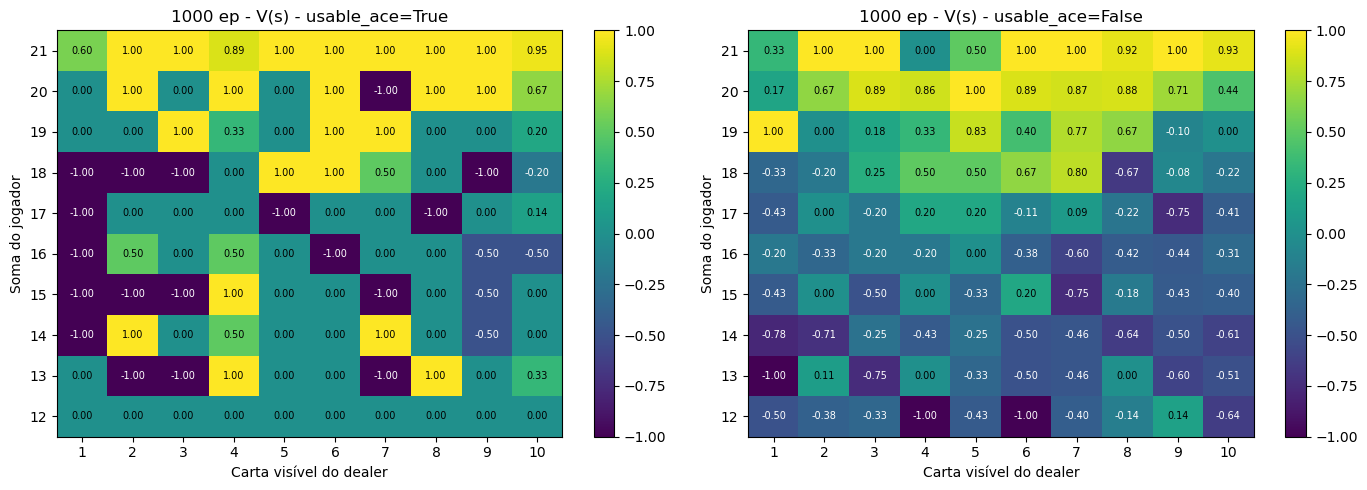


Testando com 10,000 episódios
Estados visitados: 280
Valor médio V(s): 0.0408


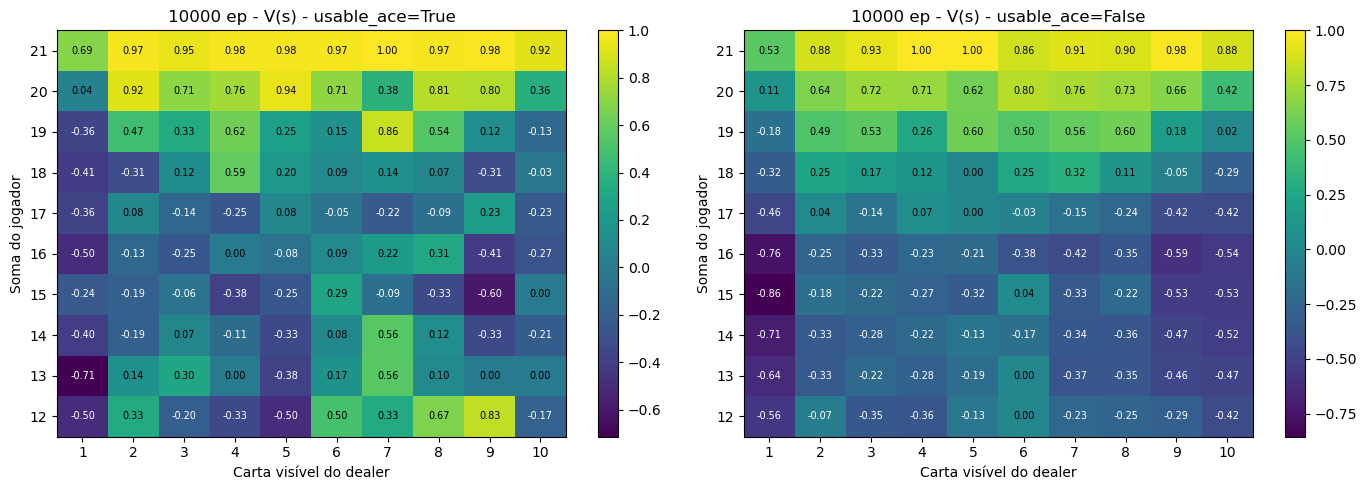


Testando com 50,000 episódios
Estados visitados: 280
Valor médio V(s): 0.0372


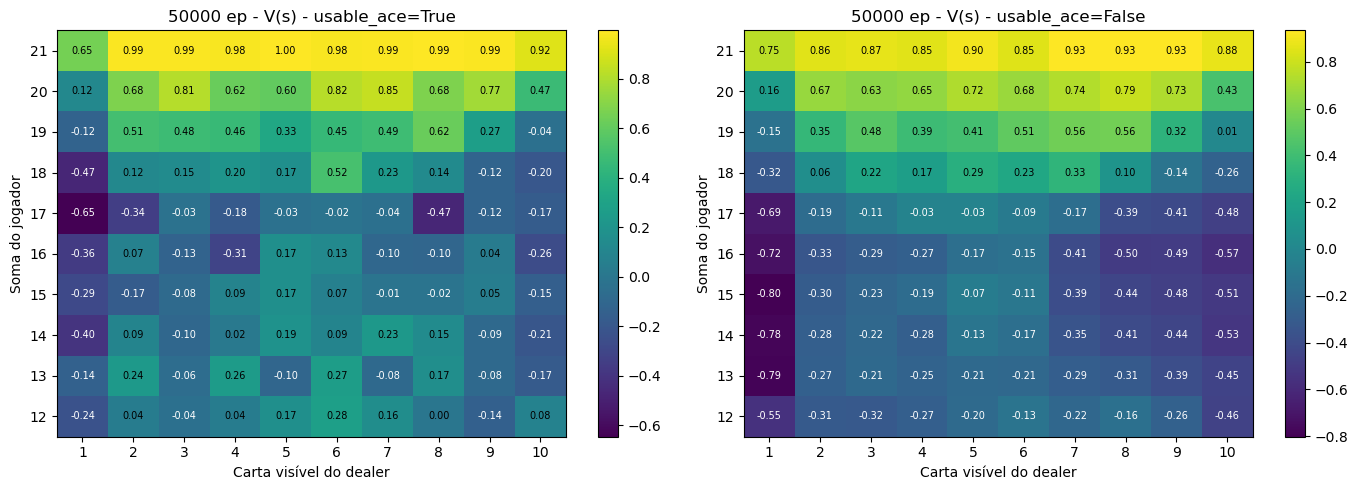

In [ ]:
# Código para executar
#import numpy as np
#import gymnasium as gym

env = gym.make('Blackjack-v1')
policy = policy_blackjack_advanced  # Política já definida no notebook

# Testar 3 quantidades de episódios
for n_ep in [1000, 10000, 50000]:
    print(f"\n{'='*50}")
    print(f"Testando com {n_ep:,} episódios")
    print(f"{'='*50}")

    V = first_visit_MC_prediction(env, policy, episodes=n_ep, gamma=1.0)

    print(f"Estados visitados: {len(V)}")
    print(f"Valor médio V(s): {np.mean(list(V.values())):.4f}")

    # Visualizar
    plot_value_heatmap(V, title_prefix=f'{n_ep} ep - ', state_values=True)

**Perguntas** (responda diretamente):

**a)** Compare os mapas de calor de 1.000 vs 50.000 episódios. Os valores mudaram muito? Em quais regiões (soma do jogador) você vê mais diferença?

**b)** O valor médio V(s) aumentou ou diminuiu com mais episódios? Por quê?

**c)** A partir de quantos episódios os mapas parecem "estáveis" (sem mudanças drásticas)?

## ⭐ Questão 2 - Comparação de Políticas (6 min)

**Contexto**: First-Visit Monte Carlo Prediction

**Tarefa Simples**:
1. Crie UMA política customizada simples, baseada nas funções
2. Execute o código de comparação
3. Responda as 3 perguntas


 COMPARAÇÃO DE POLÍTICAS

[Testando] Simples (≥20)...
  ✓ Win Rate: 30.03%
  ✓ Avg Reward: -0.3448

[Testando] Avançada...
  ✓ Win Rate: 43.48%
  ✓ Avg Reward: -0.0402

[Testando] Minha Política...
  ✓ Win Rate: 39.93%
  ✓ Avg Reward: -0.1136


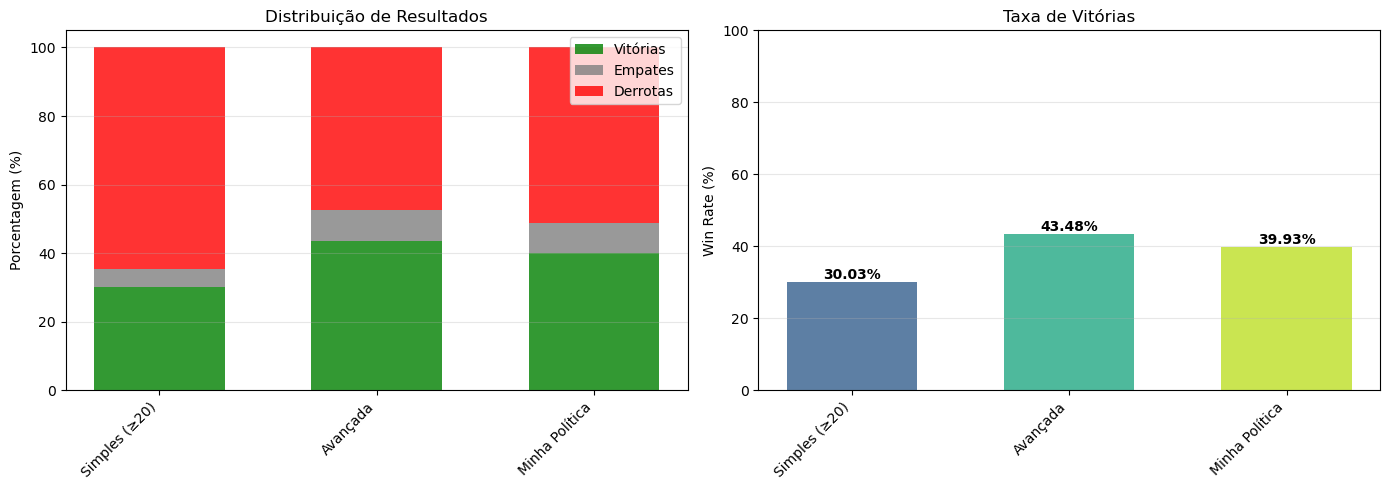

In [ ]:
# PASSO 1: Crie sua política aqui (exemplo fornecido - você pode modificar)
def minha_politica(state):
    """
    Exemplo: STICK se soma >= 18, senão HIT
    MODIFIQUE conforme sua estratégia!
    """
    player_sum, dealer_card, usable_ace = state

    # Sua regra aqui
    if player_sum >= 18:
        return 0  # STICK
    else:
        return 1  # HIT

# PASSO 2: Comparar com as políticas existentes
politicas = {
    'Simples (≥20)': policy_blackjack,
    'Avançada': policy_blackjack_advanced,
    'Minha Política': minha_politica
}

# PASSO 3: Executar comparação automática
comparacao = comparar_politicas_prediction(env, politicas, n_jogos=10000)

**Perguntas** (responda diretamente):

**a)** Qual foi a estratégia da sua política customizada?

**b)** Sua política teve win rate melhor ou pior que a "Avançada"? Qual foi a diferença percentual?

**c)** Olhando o gráfico de comparação, qual política você usaria para jogar Blackjack de verdade? Por quê?

## ⭐ Questão 3 - Efeito do Epsilon no On-Policy Control

**Contexto**: On-Policy First-Visit MC Control

**Tarefa**:
1. Execute o código com 3 valores de epsilon (ε)
2. Compare as taxas de vitória
3. Responda as 3 perguntas


Treinando com ε = 0.01

Resultados de 10000 jogos:
Vitórias:    4081 (40.81%)
Derrotas:    5109 (51.09%)
Empates:      810 ( 8.10%)
Taxa de vitórias: 40.81%


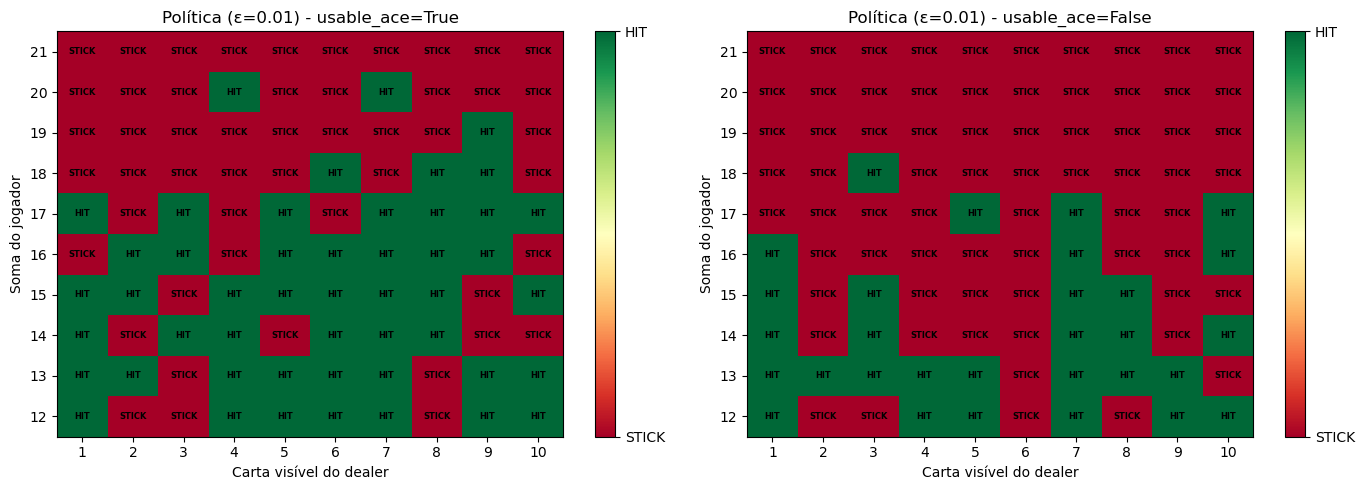


Treinando com ε = 0.1

Resultados de 10000 jogos:
Vitórias:    4310 (43.10%)
Derrotas:    4951 (49.51%)
Empates:      739 ( 7.39%)
Taxa de vitórias: 43.10%


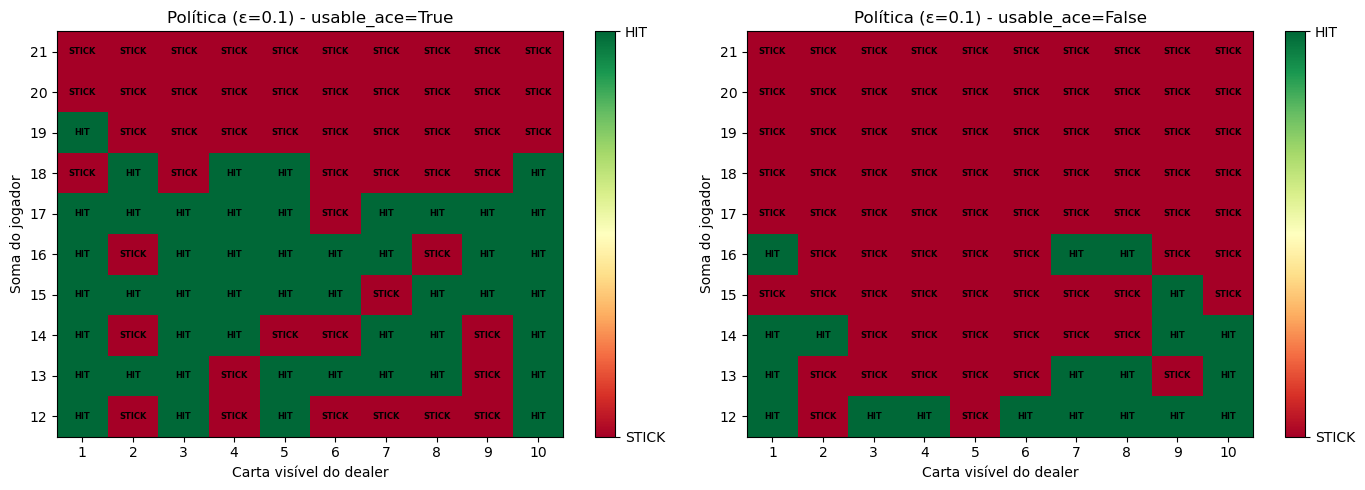


Treinando com ε = 0.3

Resultados de 10000 jogos:
Vitórias:    4334 (43.34%)
Derrotas:    4848 (48.48%)
Empates:      818 ( 8.18%)
Taxa de vitórias: 43.34%


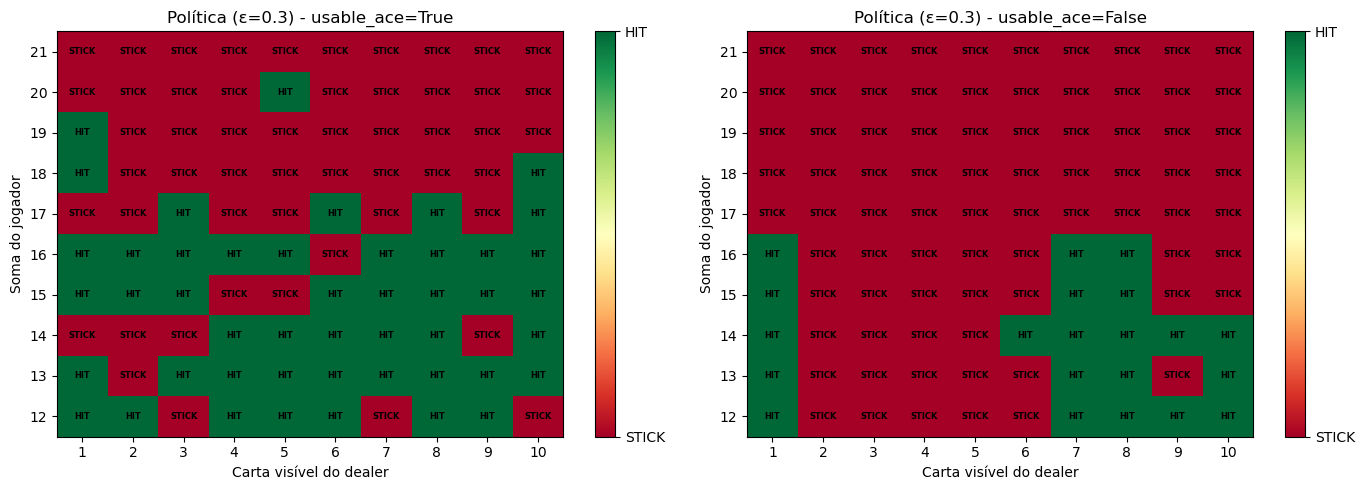


RESUMO:
ε = 0.01 → Win Rate = 40.81%
ε = 0.10 → Win Rate = 43.10%
ε = 0.30 → Win Rate = 43.34%


In [ ]:
# Código para executar
import gymnasium as gym

env = gym.make('Blackjack-v1')
env.nb_actions = 2

resultados = {}

for eps_val in [0.01, 0.1, 0.3]:
    print(f"\n{'='*50}")
    print(f"Treinando com ε = {eps_val}")
    print(f"{'='*50}")

    Q, history = on_policy_first_visit_mc_control(
        env,
        episodes=50000,
        gamma=1.0,
        eps=eps_val,
        verbose=False
    )

    # Derivar política greedy
    policy_greedy = derive_greedy_policy(Q, n_actions=2)

    # Avaliar
    stats = calcular_taxa_vitorias(env, policy_greedy, n_jogos=10000)
    resultados[eps_val] = stats

    print(f"Taxa de vitórias: {stats:.2f}%")

    # Visualizar política
    plot_policy_heatmap(policy_greedy,
                        title=f'Política (ε={eps_val})',
                        state_values=True)

# Resumo
print(f"\n{'='*50}")
print("RESUMO:")
for eps, rate in resultados.items():
    print(f"ε = {eps:.2f} → Win Rate = {rate:.2f}%")

**Perguntas**:

**a)** Qual valor de epsilon produziu a MELHOR taxa de vitória? Explique por que esse valor funcionou melhor.

**b)** Com ε = 0.3 (muito exploratório), a política aprendida foi boa? Por que epsilon muito alto pode prejudicar?

**c)** Compare as políticas visuais para ε=0.01 e ε=0.3. Elas são muito diferentes?

## ⭐⭐ Questão 4 - Monte Carlo ES Control com Exploring Starts

**Contexto**: Monte Carlo Exploring-Starts Control

**Tarefa**:
1. Execute o algoritmo MC ES com diferentes números de episódios
2. Compare com On-Policy MC Control (ε=0.1)
3. Responda as 4 perguntas

PARTE 1: MC ES Control

Treinando MC ES com 10,000 episódios...
  Win Rate: 38.96%

Treinando MC ES com 50,000 episódios...
  Win Rate: 39.82%

Treinando MC ES com 100,000 episódios...
  Win Rate: 39.84%


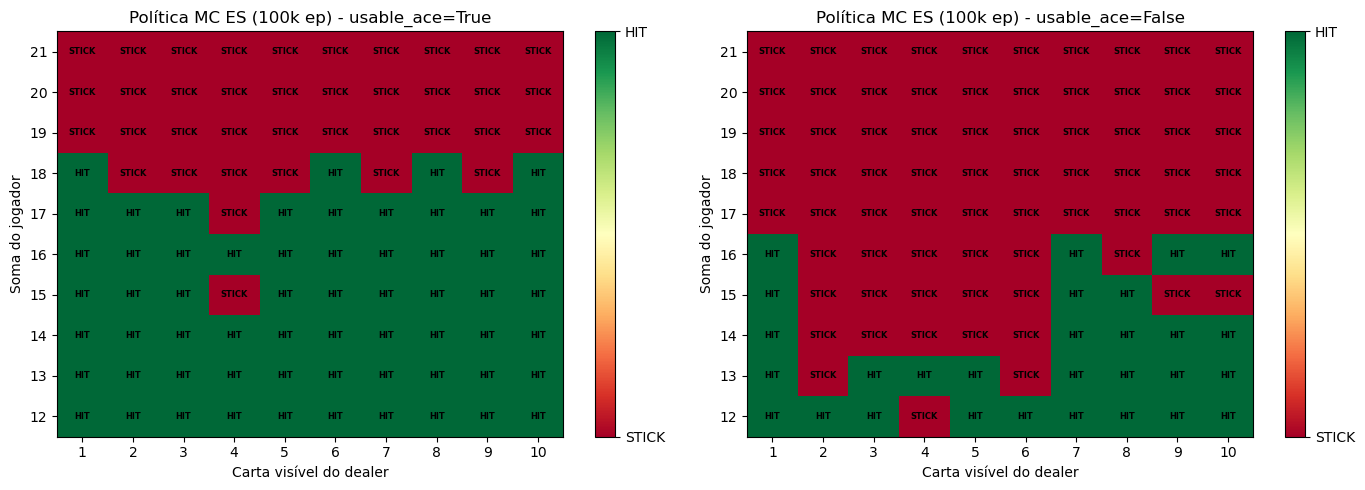


PARTE 2: Comparação MC ES vs On-Policy

Resultados de 10000 jogos:
Vitórias:    4266 (42.66%)
Derrotas:    4948 (49.48%)
Empates:      786 ( 7.86%)

MC ES (100k ep):     39.84%
On-Policy (100k ep): 42.66%
Diferença:           -2.82%


In [ ]:
# Código para executar
env_ES = BlackjackES()

print("="*60)
print("PARTE 1: MC ES Control")
print("="*60)

resultados_es = {}

for n_ep in [10000, 50000, 100000]:
    print(f"\nTreinando MC ES com {n_ep:,} episódios...")

    Q, pi, _ = monte_carlo_ES_control_ext(
        env_ES,
        episodes=n_ep,
        gamma=1.0
    )

    # Avaliar
    stats = calcular_taxa_vitorias_es(env_ES, pi, n_jogos=10000, verbose=False)
    resultados_es[n_ep] = stats['win_rate']

    print(f"  Win Rate: {stats['win_rate']:.2f}%")

# Visualizar melhor política (100k episódios)
plot_policy_heatmap(pi, title='Política MC ES (100k ep)', state_values=True)

print("\n" + "="*60)
print("PARTE 2: Comparação MC ES vs On-Policy")
print("="*60)

# Treinar On-Policy para comparação
env_on = gym.make('Blackjack-v1')
env_on.nb_actions = 2

Q_on, _ = on_policy_first_visit_mc_control(
    env_on,
    episodes=100000,
    gamma=1.0,
    eps=0.1,
    verbose=False
)

policy_on = derive_greedy_policy(Q_on, n_actions=2)
rate_on = calcular_taxa_vitorias(env_on, policy_on, n_jogos=10000)

print(f"\nMC ES (100k ep):     {resultados_es[100000]:.2f}%")
print(f"On-Policy (100k ep): {rate_on:.2f}%")
print(f"Diferença:           {resultados_es[100000] - rate_on:.2f}%")

**Perguntas**:

**a)** A taxa de vitória do MC ES melhorou significativamente de 10k para 100k episódios? Quantos pontos percentuais?

**b)** MC ES (com exploring starts) obteve melhor resultado que On-Policy (com ε-greedy)? Qual a diferença?

**c)** Qual é a vantagem do Exploring Starts sobre ε-greedy?

**d)** Para uso prático no Blackjack, qual método você prefere: MC ES ou On-Policy? Por quê?
   
   > **OBS:** Considere que para cada jogo você aposta 1.0 USD, se você ganha o jogo recebe 1.0 do dealer, se perde o dealera recebe seu USD, se vocês empatam não ganham nem perdem. Calucle o **Valor Esperado** para decidir qual o melhor método

## ⭐⭐ Questão 5 - Análise Comparativa: Prediction vs Control

**Contexto**: Comparar métodos de Prediction (avaliar política fixa) vs Control (aprender política ótima)

**Tarefa**:
1. Execute os 3 algoritmos
2. Compare os resultados
3. Responda as 4 perguntas

COMPARAÇÃO: PREDICTION vs CONTROL

[1/3] First-Visit MC Prediction...
  Política Avançada (fixa): 42.91%


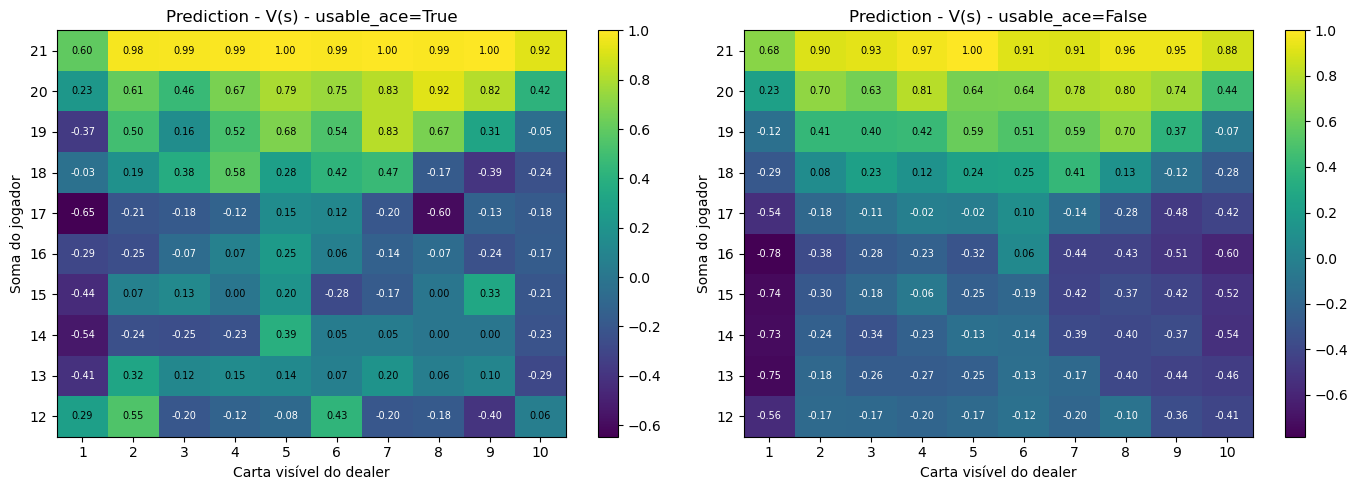


[2/3] On-Policy MC Control...

Resultados de 10000 jogos:
Vitórias:    4154 (41.54%)
Derrotas:    5017 (50.17%)
Empates:      829 ( 8.29%)
  Política Aprendida (On-Policy): 41.54%


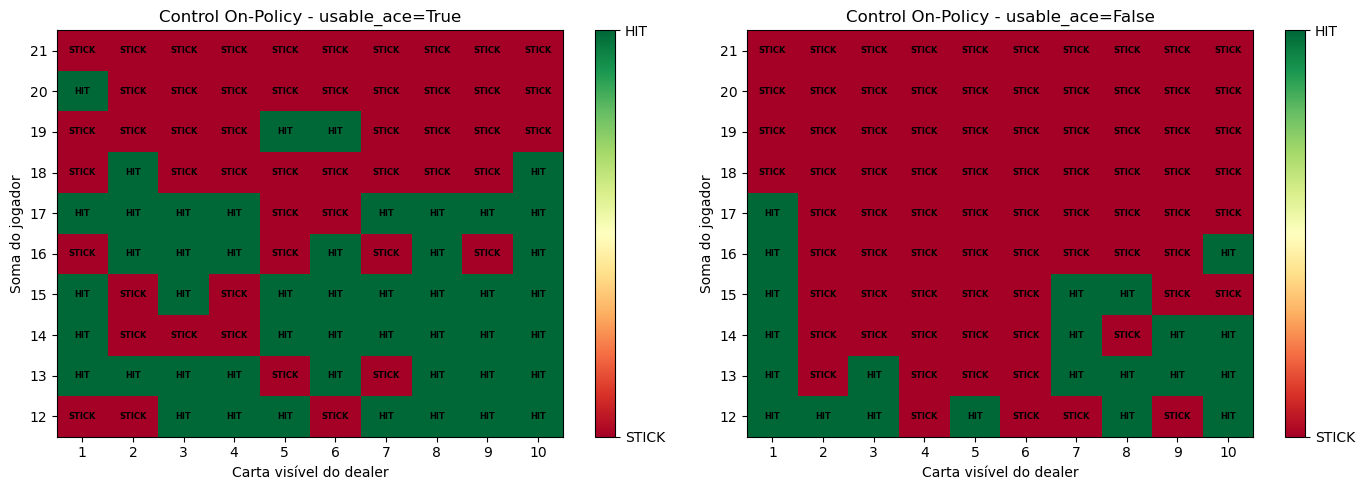


[3/3] MC ES Control...
  Política Aprendida (MC ES): 39.74%


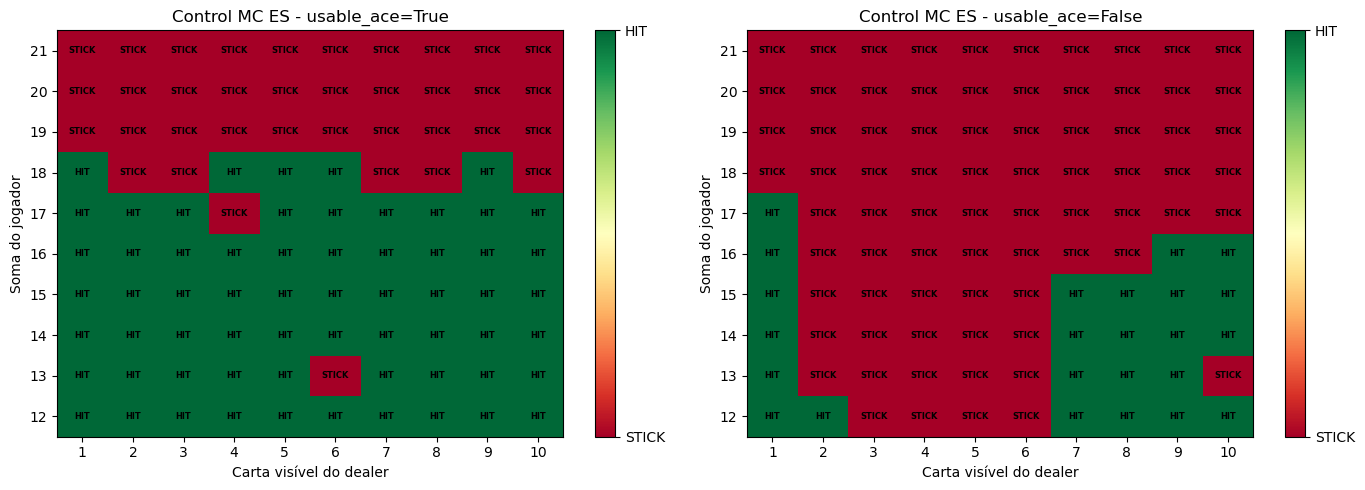


RESUMO FINAL
1. Prediction (política fixa):     42.91%
2. On-Policy Control (aprendeu):   41.54%
3. MC ES Control (aprendeu):       39.74%

Melhor método: Prediction com 42.91%


In [ ]:
print("="*60)
print("COMPARAÇÃO: PREDICTION vs CONTROL")
print("="*60)

# 1. First-Visit MC PREDICTION com política avançada
print("\n[1/3] First-Visit MC Prediction...")
V_pred = first_visit_MC_prediction(
    env,
    policy_blackjack_advanced,
    episodes=20000,
    gamma=1.0,
    verbose=False
)

stats_pred = avaliar_politica_prediction(
    env,
    policy_blackjack_advanced,
    n_jogos=10000,
    verbose=False
)

print(f"  Política Avançada (fixa): {stats_pred['win_rate']:.2f}%")
plot_value_heatmap(V_pred, title_prefix='Prediction - ', state_values=True)

# 2. On-Policy MC CONTROL
print("\n[2/3] On-Policy MC Control...")
Q_control, _ = on_policy_first_visit_mc_control(
    env,
    episodes=50000,
    gamma=1.0,
    eps=0.1,
    verbose=False
)

policy_control = derive_greedy_policy(Q_control, n_actions=2)
rate_control = calcular_taxa_vitorias(env, policy_control, n_jogos=10000)

print(f"  Política Aprendida (On-Policy): {rate_control:.2f}%")
plot_policy_heatmap(policy_control, title='Control On-Policy', state_values=True)

# 3. MC ES CONTROL
print("\n[3/3] MC ES Control...")
Q_es, pi_es, _ = monte_carlo_ES_control_ext(
    env_ES,
    episodes=50000,
    gamma=1.0
)

stats_es = calcular_taxa_vitorias_es(env_ES, pi_es, n_jogos=10000, verbose=False)

print(f"  Política Aprendida (MC ES): {stats_es['win_rate']:.2f}%")
plot_policy_heatmap(pi_es, title='Control MC ES', state_values=True)

# Resumo final
print("\n" + "="*60)
print("RESUMO FINAL")
print("="*60)
print(f"1. Prediction (política fixa):     {stats_pred['win_rate']:.2f}%")
print(f"2. On-Policy Control (aprendeu):   {rate_control:.2f}%")
print(f"3. MC ES Control (aprendeu):       {stats_es['win_rate']:.2f}%")
print(f"\nMelhor método: ", end="")
best = max([
    ('Prediction', stats_pred['win_rate']),
    ('On-Policy', rate_control),
    ('MC ES', stats_es['win_rate'])
], key=lambda x: x[1])
print(f"{best[0]} com {best[1]:.2f}%")

**Perguntas**:

**a)** Os métodos de Control (aprenderam política) superaram o Prediction (política fixa avançada)? Por quanto?

**b)** Entre On-Policy Control e MC ES Control, qual obteve melhor resultado? Qual a diferença?

**c)** Olhando os mapas de política, as 3 políticas (avançada fixa, On-Policy aprendida, MC ES aprendida) são similares ou muito diferentes? Onde diferem mais?

**d)** Baseado nos resultados, você diria que a "política avançada" pré-definida já é próxima da ótima, ou os algoritmos de Control conseguiram melhorar significativamente?